# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm

from shapely.geometry import Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [3]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [4]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [5]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [42]:
def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-20,20,20)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [65]:
def calc_circle_cp_by_mascon(LgE, L):
    
    import geopandas as gpd
    from shapely.geometry import Point, Polygon

    # Convert catalog to GeoDataFrame
    geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
    catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")# Handle the earthquakes by "mascon"
    
    mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

    mascon_center_lat = mascon['mascon_lat'].data
    mascon_center_lon = mascon['mascon_lon'].data
    mascon_id = mascon['mascon_id'].data
    cap_radius_deg = 1.5  # Spherical cap radius in degrees

    cp = []

    # Create spatial index for catalog_gdf to optimize spatial joins
    catalog_gdf.sindex

    # Iterate through each mascon center
    # for i in tqdm(range(len(mascon_id))):
    for i in range(len(mascon_id)):
        # Create a Point for the mascon center
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])

        # Define a circular buffer (spherical cap) with a 1.5-degree radius
        bbox = center_point.buffer(cap_radius_deg)

        # Convert the buffer to a GeoDataFrame for spatial operations
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Spatial join to find earthquakes within the spherical cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # Skip to the next iteration if no earthquakes are found within this cap
        if these_earthquakes.empty:
            continue

        # Retrieve load data for this mascon using the center coordinates
        these_loads = ds.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest")['lwe_thickness'].data.flatten()

        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos(cap_radius_deg * np.pi / 180)) / 2 * 510e6 / 1e5  # area per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng

        # Compute P(E|L)
        circle_bins, this_cp = get_cp(LgE, L)
        this_cp = this_cp * E
        cp.append(this_cp)

    # Average conditional probabilities across all mascons
    circle_cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return circle_cp_averaged, circle_bins

In [50]:
def calc_square_cp_by_mascon(LgE, L):
    
    import geopandas as gpd
    from shapely.geometry import Point, Polygon

    # Convert catalog to GeoDataFrame
    geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
    catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")# Handle the earthquakes by "mascon"

    # Load mascon center coordinates and IDs
    mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
    
    mascon_center_lat = mascon['mascon_lat'].data
    mascon_center_lon = mascon['mascon_lon'].data
    mascon_id = mascon['mascon_id'].data

    cp = []

    # Create spatial index for catalog_gdf to optimize spatial joins
    catalog_gdf.sindex  # Builds the spatial index for faster queries

    # Iterate through each mascon center
    # for i in tqdm(range(len(mascon_id))):
    for i in range(len(mascon_id)):
        # Define approximate bounds based on a 3-degree mascon size (1.5 degrees around center)
        lat_min = mascon_center_lat[i] - 1.5
        lat_max = mascon_center_lat[i] + 1.5
        lon_min = mascon_center_lon[i] - 1.5
        lon_max = mascon_center_lon[i] + 1.5

        # Clamp latitude bounds between -90 and 90
        lat_min, lat_max = max(lat_min, -90), min(lat_max, 90)

        # Normalize longitude bounds to [-180, 180]
        lon_min = (lon_min + 180) % 360 - 180
        lon_max = (lon_max + 180) % 360 - 180

        # Define bounding box polygon
        if lon_min <= lon_max:
            bbox = Polygon([
                (lon_min, lat_min), (lon_min, lat_max),
                (lon_max, lat_max), (lon_max, lat_min)
            ])
        else:
            # Handle antimeridian crossing by creating a bounding box that wraps around
            bbox = Polygon([(-180, lat_min), (-180, lat_max), (180, lat_max), (180, lat_min)])

        # Create GeoDataFrame for bounding box
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Spatial join to find earthquakes within the bounding box
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')

        # Skip to next iteration if no earthquakes
        if these_earthquakes.empty:
            continue

        # Retrieve load data for this mascon using the center coordinates
        # Assuming `ds` is a gridded dataset that can be indexed by lat/lon indices
        these_loads = ds.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest")['lwe_thickness'].data.flatten()

        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 510e6 / 1e5  # per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng

        # Compute P(E|L)
        if len(LgE) > 0:
            square_bins, this_cp = get_cp(LgE, L)
            this_cp = this_cp * E
            cp.append(this_cp)

    # Average conditional probabilities across all mascons
    square_cp_averaged = np.nanmean(np.array(cp), axis=0)
    
    return square_cp_averaged, square_bins

20
19


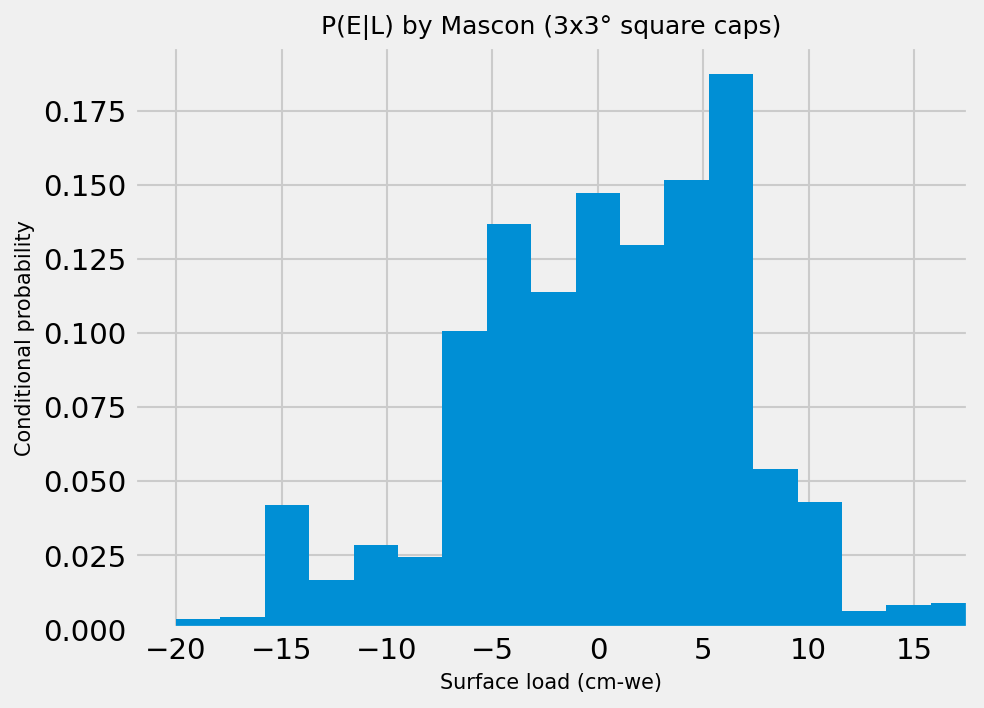

In [52]:
# Plot the averaged conditional probabilities
plt.style.use('fivethirtyeight')

# bins = np.linspace(-20,20,len(cp_averaged) + 1) # there is no "set" num of bins since its calculated for each cp, not for cp_averaged
wid = np.mean(np.diff(bins))

print(len(square_bins))
print(len(square_cp_averaged))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=150)

# Plot the bar chart
ax.bar(square_bins[:-1], square_cp_averaged, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon (3x3\N{DEGREE SIGN} square caps)', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

20
19


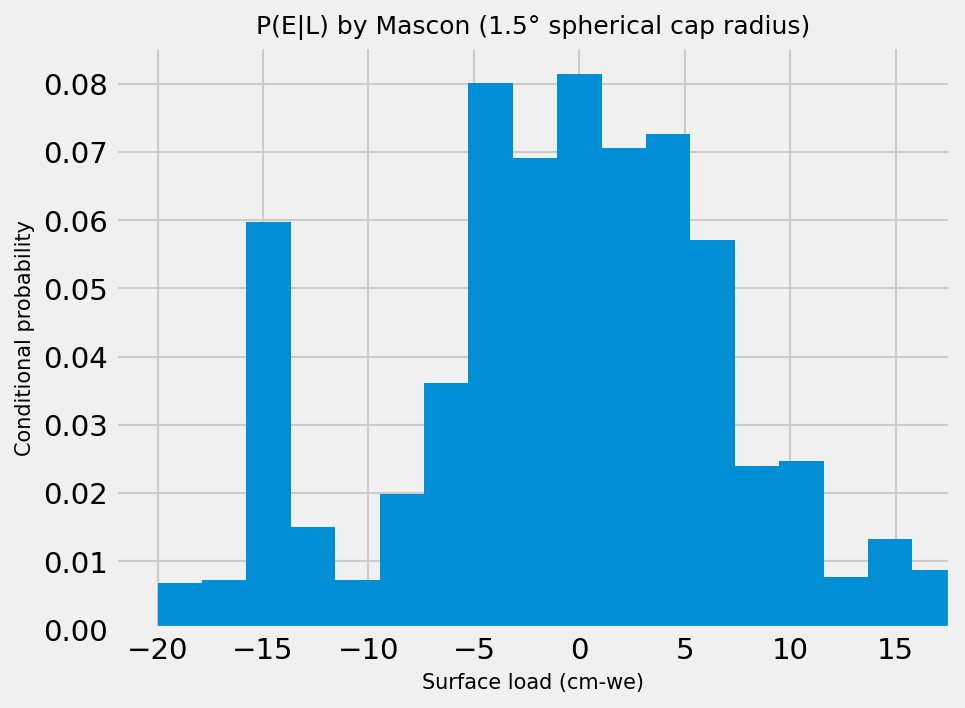

In [54]:
# Plot the averaged conditional probabilities
plt.style.use('fivethirtyeight')

# bins = np.linspace(-20,20,len(cp_averaged) + 1) # there is no "set" num of bins since its calculated for each cp, not for cp_averaged
wid = np.mean(np.diff(bins))

print(len(circle_bins))
print(len(circle_cp_averaged))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=150)

# Plot the bar chart
ax.bar(circle_bins[:-1], circle_cp_averaged, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon (1.5\N{DEGREE SIGN} spherical cap radius)', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

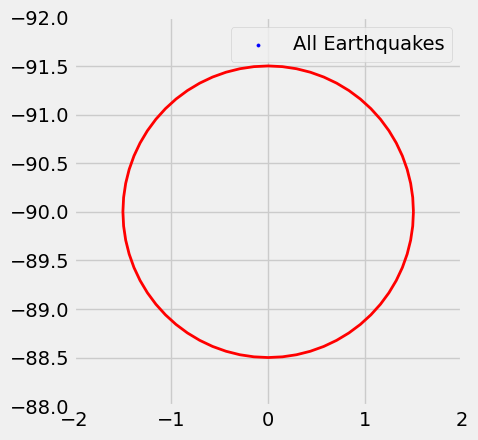

In [55]:
'''
Sanity Check!
'''
base = bbox_gdf.boundary.plot(color='red', linewidth=2)
catalog_gdf.plot(ax=base, marker='o', color='blue', markersize=5, label='All Earthquakes')
# these_earthquakes.plot(ax=base, marker='o', color='red', markersize=5, label='Selected Earthquakes')
plt.xlim([-2,2])
plt.ylim([-88,-92])
plt.legend()
plt.show()

# Significance testing

1. Scramble loads
2. Get cps repeatedly

In [66]:
# Flatten the surface load dataset to scramble
all_grace_data = np.array(ds.lwe_thickness).flatten()
rng = np.random.default_rng()  # Random number generator

cp_real_distribution = []
N = 100  # Number of randomizations

# Scramble and calculate cp for each randomization
for i in tqdm(range(N)):
    scrambled_data = rng.permutation(all_grace_data)
    circle_cp_averaged, circle_bins = calc_circle_cp_by_mascon(LgE, scrambled_data)
    cp_real_distribution.extend(circle_cp_averaged)

cp_real_distribution = np.array(cp_real_distribution)

  0%|                                                     | 0/100 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: R

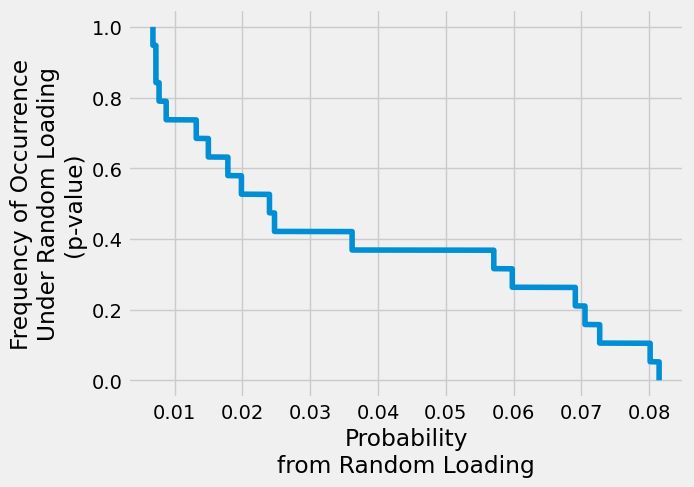

In [67]:
# Visualization of significance testing
sorted_data = np.sort(cp_real_distribution)
plt.plot(sorted_data, 1 - np.arange(sorted_data.size) / sorted_data.size)
# plt.scatter(p10, 0.1, c='r', zorder=29)  # Replace `p10` with your observed value
plt.ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)')
plt.xlabel('Probability\nfrom Random Loading')
plt.show()